In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
dataset = 'classa'

In [4]:
# Read our results

import json

def combine_dict(dict1, dict2):
    for key in dict2.keys():
        if key in dict1:
            dict1[key] = combine_dict(dict1[key], dict2[key])
        else:
            dict1[key] = dict2[key]
    return dict1

def combine_dicts(dicts):
    u = None
    for d in dicts:
        if u is None:
            u = d
        else:
            u = combine_dict(u, d)
    return u

In [5]:
import site

site.addsitedir("/home/xyhang/projects/VCIP2023-grand-challenge/")

from tools.bdrate import BD_RATE, BD_PSNR

In [6]:
from dataclasses import dataclass
from typing_extensions import TypeAlias, List, Dict
import numpy as np

@dataclass
class ResultUnit:
    r: float
    d: float
    t: float

ImageResults: TypeAlias = List[ResultUnit]

class DatasetResults:
    def __init__(self):
        self.img_results: Dict[str, ImageResults] = {}

    def update_image_result(self, img_name, r, d, t):
        self.img_results.setdefault(img_name, []).append(ResultUnit(r=r, d=d, t=t))

    def sort(self):
        for k in self.img_results.keys():
            self.img_results[k].sort(key=lambda x: x.r)

    @property
    def avg_r(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.r for x in rs]))
        return results

    @property
    def avg_d(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.d for x in rs]))
        return results

    @property
    def avg_t(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.t for x in rs]))
        return results

    def _bd_rate_imgwise(self, anchor, min_int=None, max_int=None):
        self.sort()
        anchor.sort()
        ans = {}
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            R1 = np.unique(R1)
            R2 = np.unique(R2)
            D1 = np.unique(D1)
            D2 = np.unique(D2)

            if min_int is not None and max_int is not None:
                bd_rate = BD_RATE(R1, D1, R2, D2, min_int=min_int[filename], max_int=max_int[filename])
            else:
                bd_rate = BD_RATE(R1, D1, R2, D2)

            ans[filename] = bd_rate
        return ans

    def bd_rate(self, anchor, min_int=None, max_int=None):
        ans = self._bd_rate_imgwise(anchor, min_int, max_int)
        return np.mean(list(ans.values()))

    def bd_psnr(self, anchor):
        self.sort()
        anchor.sort()
        ans = []
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            R1 = np.unique(R1)
            R2 = np.unique(R2)
            D1 = np.unique(D1)
            D2 = np.unique(D2)
            bd_rate = BD_PSNR(R1, D1, R2, D2)
            ans.append(bd_rate)
        return np.mean(ans)

    def time_saving(self, anchor):
        self.sort()
        anchor.sort()
        ans = []

In [7]:
def read_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [8]:
import glob

results = glob.glob(f"{dataset}/*.json")

data_ours = combine_dicts([read_json(r) for r in results])

In [9]:
# speedups = [0.01, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
speedups = [0.01,0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0]
qscales = [0.1, 0.3, 0.5, 0.7, 0.9]
# qscales = [0.3,0.4,0.5,0.6,0.7]

In [10]:
ours_results = {k: DatasetResults() for k in speedups}

for speedup in speedups:
    for qscale in qscales:
        glob_results = data_ours[f"qscale={qscale}"][f"speedup={speedup}"]
        for filename, result in glob_results.items():
            if filename[:3] != "avg":
                ours_results[speedup].update_image_result(
                    filename, result["bpp"], result["PSNR"], result["t_dec"]
                )

In [11]:
if dataset == 'classd':
    cbanet_levels = [1, 2, 3]
    cbanet_results = {k: DatasetResults() for k in cbanet_levels}
    data_cbanet = read_json(f"../../anchors/{dataset}/results_cbanet.json")

    for level in cbanet_levels:
        for bpp in [1,2,3,4]:
            glob_results = data_cbanet[f"{bpp}"][f"width={level}"]
            for filename, result in glob_results.items():
                if filename[:3] != "avg":
                    cbanet_results[level].update_image_result(
                        filename, result["bpp"], result["PSNR"], result["t_dec"] + 0.05 # ANS time extra
                    )

In [12]:
import pandas as pd

def read_xls(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df

In [13]:
anchors = ['bpg', 'evc', 'jpeg', 'mlic', 'qarv', 'tcm', 'webp', 'vtm']

anchor_results: Dict[str, DatasetResults] = {k: DatasetResults() for k in anchors}

anchors_r = {}
anchors_d = {}
anchors_t = {}

for anchor in anchors:
    if anchor == 'vtm':
        xls_data: pd.DataFrame = read_xls(f"VTM.xls", dataset)
        filename = None
        for index, x in xls_data.iterrows():
            if isinstance(x.Filename, (str, int)) or (isinstance(x.Filename, float) and not np.isnan(x.Filename)):
                if isinstance(x.Filename, float):
                    filename = str(int(x.Filename))
                else:
                    filename = str(x.Filename)
            anchor_results[anchor].update_image_result(
                filename, x.bpp, x["RGB psnr"], x["Dec Time"] * 6.734
            )
    else:
        anchor_data = read_json(f"../../anchors/{dataset}/{anchor}/results.json")
        if anchor == 'bpg' and dataset == 'classa':
            for t1 in anchor_data.values():
                for t2 in t1.values():
                    for filename, result in t2.items():
                        if filename[:3] != "avg":
                            anchor_results[anchor].update_image_result(
                                filename, result["bpp"], result["PSNR"], result["t_dec"]
                            )
        else:
            for t2 in anchor_data.values():
                for filename, result in t2.items():
                    if filename[:3] != "avg":
                        anchor_results[anchor].update_image_result(
                            filename, result["bpp"], result["PSNR"], result["t_dec"]
                        )

In [14]:
import scipy


def interpolator(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    lin = np.linspace(min(x), max(x), num=100, retstep=True)
    samples = lin[0]
    v = scipy.interpolate.pchip_interpolate(
        np.sort(x), y[np.argsort(x)], samples
    )

    return samples, v

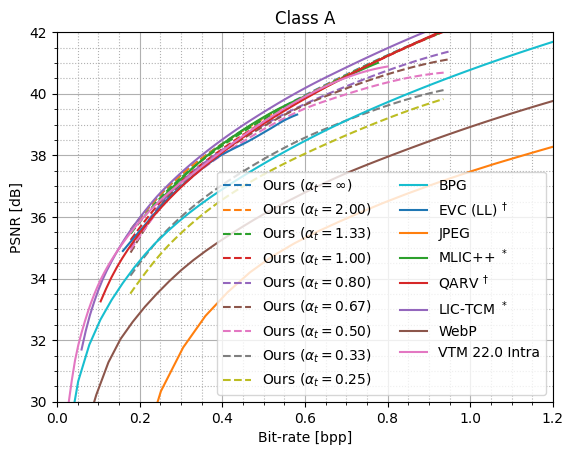

In [15]:
plt.figure(figsize=(6.4, 4.8))

name_mapping = {
    "evc": r"EVC (LL) $^\dag$",
    "mlic": "MLIC++ $^*$",
    "tcm": "LIC-TCM $^*$",
    "vtm": "VTM 22.0 Intra",
    "qarv": "QARV $^\dag$",
    "bpg": "BPG",
    "webp": "WebP",
    "jpeg": "JPEG",
}

for speedup in speedups:
    r = ours_results[speedup].avg_r
    d = ours_results[speedup].avg_d
    r, d = interpolator(r, d)

    dt = 1.0 / speedup
    label = (
        f"Ours ($\\alpha_t={dt:.2f}$)" if dt <= 10 else f"Ours ($\\alpha_t=\\infty$)"
    )

    plt.plot(
        r,
        d,
        linestyle="--",
        label=label,
    )

for k, v in anchor_results.items():
    r = v.avg_r
    d = v.avg_d
    r, d = interpolator(r, d)
    plt.plot(r, d, label=name_mapping[k])
plt.legend(ncol=2)
plt.xlim(0.0, 1.2)
plt.ylim(30, 42)

plt.xlabel("Bit-rate [bpp]")
plt.ylabel("PSNR [dB]")
plt.minorticks_on()
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle=":")
titles = {
    "classa": "Class A",
    "classb": "Class B",
    "classc": "Class C",
    "classd": "Kodak",
}
plt.title(titles[dataset])

plt.savefig(f"{dataset}_rd.pdf", bbox_inches="tight")
plt.savefig(f"{dataset}_rd.png", dpi=600, bbox_inches="tight")
plt.show()

{'DOG_4507': 37.03661849477224, 'DSC07099': 33.94674947240286, 'DSC07705': 33.8538592097991, 'DSC08582': 34.963611864828394, 'DSC08626': 40.77764978387289, 'DSC08672': 33.23684861638479, 'DSC08796': 32.067240977072046, 'DSC08892': 35.86183001973562, 'DSC08902': 37.7948992488616, 'DSC08928': 36.77709271886282, 'DSC08936': 38.79318883397512, 'DSC_3889': 36.6490035293334, 'IMG_1813': 33.69363357999258, 'IMG_3227': 38.99428656079702, 'IMG_3261': 39.53835179784231, 'IMG_3412': 36.435851359152124, 'IMG_3515': 35.93480637051992, 'IMG_3799': 37.71086027600698, 'IMG_4684': 36.76716377713613, 'IMG_4700': 33.973989987158106, 'IMG_6726': 36.75295164563589, 'IMG_7136': 35.540335678839014, 'IMG_8176': 37.064728045248316, 'IMG_8795': 41.95022990682058}
{'DOG_4507': 40.251286530279444, 'DSC07099': 36.802360319876, 'DSC07705': 37.395921253942774, 'DSC08582': 37.8781442878478, 'DSC08626': 42.30256547906332, 'DSC08672': 36.54805829503469, 'DSC08796': 34.83493974187307, 'DSC08892': 38.365077280782984, 'DS

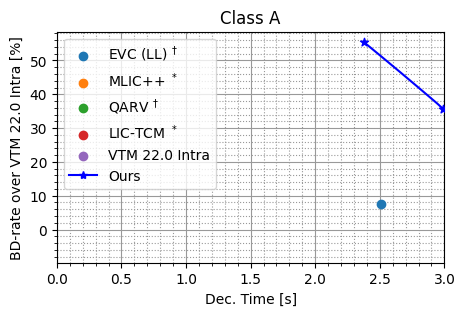

In [16]:
anchor = anchor_results['vtm']
min_int = {}
max_int = {}

for filename in anchor.img_results.keys():
    min_int[filename] = max(
        [
            min([x.d for x in data.img_results[filename]])
            for data in anchor_results.values()
        ]
        + [
            min([x.d for x in data.img_results[filename]])
            for data in ours_results.values()
        ]
    )
    max_int[filename] = min(
        [
            max([x.d for x in data.img_results[filename]])
            for data in anchor_results.values()
        ]
        + [
            max([x.d for x in data.img_results[filename]])
            for data in ours_results.values()
        ]
    )

print(min_int)
print(max_int)

plt.figure(figsize=(5, 3))

ts = {}
bds = {}

for k, v in anchor_results.items():
    bd = v.bd_rate(anchor, min_int, max_int)
    t = np.mean(v.avg_t)
    ts[k] = t
    bds[k] = bd

for k, v in anchor_results.items():
    if k == 'evc':
        ts[k] = ts['qarv'] / 3.8
    if k not in ['jpeg', 'bpg', 'webp']:
        marker = 'o'
        plt.scatter(ts[k], bds[k], label=name_mapping[k], zorder=10, marker=marker)
    print(k, ts[k], bds[k])

if dataset == "classd":
    gao_t = np.array([0.2, 1.7, 3.1, 4.4, 7.3]) / 2.0
    gao_bd = [8.7, 6.0, 5.0, 4.0, 3.0]
    t, bd = interpolator(gao_t, gao_bd)
    plt.plot(t, bd, color="orange")
    plt.scatter(gao_t, gao_bd, marker="o", color="orange")
    plt.plot([-1], [0], color="orange", marker="o", label="Gao et.al")

    cba_bd = []
    cba_t = []

    for k, v in cbanet_results.items():
        bd = v.bd_rate(anchor, min_int, max_int)
        t = np.mean(v.avg_t)
        cba_bd.append(bd)
        cba_t.append(t)
    
    plt.plot(cba_t, cba_bd, color='teal')
    plt.scatter(cba_t, cba_bd, marker='o', color='teal', zorder=10)
    plt.plot([-1], [0], marker="o", color="teal", label="CBANet")

    # plt.title(titles[dataset])
    # plt.legend()

    # plt.savefig(f"{dataset}_bd_gao.pdf", bbox_inches="tight")
    # plt.savefig(f"{dataset}_bd_gao.png", dpi=600, bbox_inches="tight")

ours_bd = []
ours_t = []

for k, v in ours_results.items():
    bd = v.bd_rate(anchor, min_int, max_int)
    t = np.mean(v.avg_t)
    t = min(t, ts['qarv'] / k)
    ours_bd.append(bd)
    ours_t.append(t)

print(ours_t, ours_bd)

ours_t = np.asarray(ours_t)
ours_bd = np.asarray(ours_bd)
ours_bd, ours_t = np.sort(ours_bd), ours_t[np.argsort(ours_bd)]
t, bd = interpolator(ours_t, ours_bd)

plt.plot(t, bd, color='blue')
plt.scatter(ours_t, ours_bd, marker='*', color='blue', zorder=10)
plt.plot([-1], [0], marker="*", color="blue", label="Ours")
plt.xlabel("Dec. Time [s]")
plt.xlim(0, 3.0)
plt.ylabel("BD-rate over VTM 22.0 Intra [%]")
plt.minorticks_on()
plt.grid(zorder=0, which='major', color='#999999', linestyle='-')
plt.grid(zorder=0, which='minor', color='#999999', linestyle=':')
titles = {
    "classa": "Class A",
    "classb": "Class B",
    "classc": "Class C",
    "classd": "Kodak",
}
plt.title(titles[dataset])

plt.legend()

plt.savefig(f"{dataset}_bd_c.pdf", bbox_inches='tight')
plt.savefig(f"{dataset}_bd_c.png", dpi=600, bbox_inches="tight")

In [17]:
ours_bd, ours_t

(array([-5.43344523, -5.38006169, -3.41967086, -0.62491971,  0.63015651,
         1.660455  ,  4.06784462, 35.78468527, 55.39852058]),
 array([16.35336508, 14.22935894, 11.67001507,  9.5258653 ,  7.62069224,
         6.35057687,  3.92684523,  2.98981101,  2.37758513]))

In [18]:
# Accelerate Effect

import scipy.interpolate


for method in ts.keys():
    t = ts[method]
    bd = bds[method]

    t_est = scipy.interpolate.pchip_interpolate(ours_bd, ours_t, bd)
    print(method, 100*(t_est-t)/t)

bpg -64.61420782454624
evc 47.272371026323455
jpeg -733.4189463423588
mlic -63.979066946443055
qarv -46.4132431112632
tcm -134840.2868780534
webp -109.02266518085592
vtm 6.045485062911074


In [19]:
# Accelerate Effect

import scipy.interpolate

ours_t = np.asarray(ours_t)
ours_bd = np.asarray(ours_bd)

print(ours_t, ours_bd, flush=True)

for method in ts.keys():
    t = ts[method]
    bd = bds[method]
    if t > max(ours_t):
        bd_est = min(ours_bd)
    else:
        X = np.sort(ours_t)
        Y = ours_bd[np.argsort(ours_t)]
        bd_est = scipy.interpolate.pchip_interpolate(X, Y, t)
    print(method, bd_est - bd)

[16.35336508 14.22935894 11.67001507  9.5258653   7.62069224  6.35057687
  3.92684523  2.98981101  2.37758513] [-5.43344523 -5.38006169 -3.41967086 -0.62491971  0.63015651  1.660455
  4.06784462 35.78468527 55.39852058]
bpg -41.808990610271685
evc 43.83525087554633
jpeg -134.35875514906635
mlic -3.4405401529633384
qarv -3.2650347678344187
tcm 1.2761474954860095
webp -25.759088867187515
vtm 0.29445437955412873


In [20]:
import matplotlib as mpl

def plot_img_results(results: DatasetResults, anchor: DatasetResults, rng_anchor: DatasetResults = None):
    ans_results = results._bd_rate_imgwise(anchor, min_int, max_int)
    ans_results = [(k, v) for k, v in ans_results.items()]
    ans_results.sort(key=lambda x: x[1])
    print(ans_results)
    plt.figure(figsize=(10, 3))

    cm = mpl.colormaps['coolwarm']
    labels, values = zip(*ans_results)
    colors = np.asarray(values)
    colors = colors / (np.abs(colors).max())
    colors = colors / 2 + 0.5
    colors = [cm(k) for k in colors]
    plt.bar(labels, values, color=colors, zorder=10)
    plt.ylabel("BD-rate (%)")
    plt.grid(axis='y', zorder=0)
    plt.xticks(rotation=90)

In [21]:
import matplotlib as mpl


def plot_img_results_comparison(
    results1: DatasetResults, results2, anchor: DatasetResults
):
    ans_results1 = results1._bd_rate_imgwise(anchor)
    ans_results2 = results2._bd_rate_imgwise(anchor)
    ans_results2 = [(k, ans_results1[k] - v) for k, v in ans_results2.items()]
    ans_results2.sort(key=lambda x: x[1])
    print(ans_results2)
    plt.figure(figsize=(10, 3))

    cm = mpl.colormaps["coolwarm"]
    labels, values = zip(*ans_results2)
    colors = np.asarray(values)
    colors = colors / (np.abs(colors).max())
    colors = colors / 2 + 0.5
    colors = [cm(k) for k in colors]
    plt.bar(labels, values, color=colors, zorder=10)
    plt.ylabel("BD-rate (%)")
    plt.grid(axis="y", zorder=0)
    plt.xticks(rotation=90)

[('DSC08892', -4.013506439239456), ('DSC08928', -3.1189953724899633), ('DSC08796', -2.4775329697785065), ('IMG_7136', -2.398184348228216), ('IMG_4684', -1.99296641151393), ('DSC07099', -0.17048112404921545), ('IMG_6726', -0.06542045266380025), ('IMG_3412', 0.11996689013495931), ('IMG_4700', 0.25581050530170124), ('IMG_8795', 1.3389181974480913), ('IMG_1813', 18.402118955815382), ('DSC08672', 26.149038123614798), ('IMG_3227', 28.541991607639172), ('IMG_8176', 32.38560137378925), ('DSC08582', 38.91468981993391), ('IMG_3799', 38.99831756087093), ('DOG_4507', 41.660460791472545), ('DSC_3889', 50.55360942964595), ('IMG_3261', 55.17559744370939), ('DSC08626', 56.98723624323374), ('DSC08936', 59.345805669415874), ('IMG_3515', 60.881311596539554), ('DSC07705', 61.885273235488114), ('DSC08902', 76.00103830698923)]


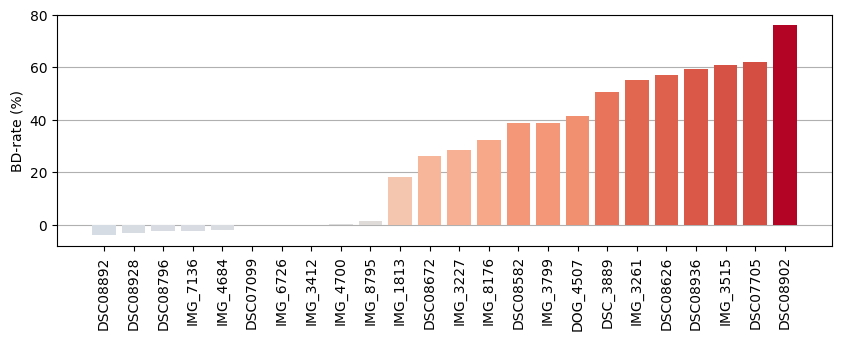

In [22]:
plot_img_results(ours_results[3.0], anchor_results["evc"])

[('IMG_8795', -35.185079115939686), ('IMG_3227', -22.219742957673915), ('DSC08936', -12.823625984176058), ('DSC08902', -10.683032540087488), ('IMG_3261', -9.686159646050108), ('DSC08626', -9.184033323435504), ('IMG_3799', -9.086851104374782), ('IMG_8176', -8.406311296465717), ('DSC_3889', -5.608653810687292), ('IMG_7136', -5.181438912374125), ('DSC07099', -4.727189433799161), ('DSC08928', -4.4952812673053835), ('DSC08892', -4.439717045638825), ('DOG_4507', -3.6577753343325803), ('IMG_4684', -3.548752988644055), ('IMG_3515', -3.0854179852677905), ('IMG_1813', -3.059588608808983), ('DSC07705', -2.962138008967319), ('IMG_3412', -2.9368299095425154), ('IMG_6726', -2.2425531790298816), ('DSC08582', -1.5108901466423186), ('IMG_4700', -1.51052719732132), ('DSC08796', -1.4777696221328407), ('DSC08672', 0.18222219231267545)]


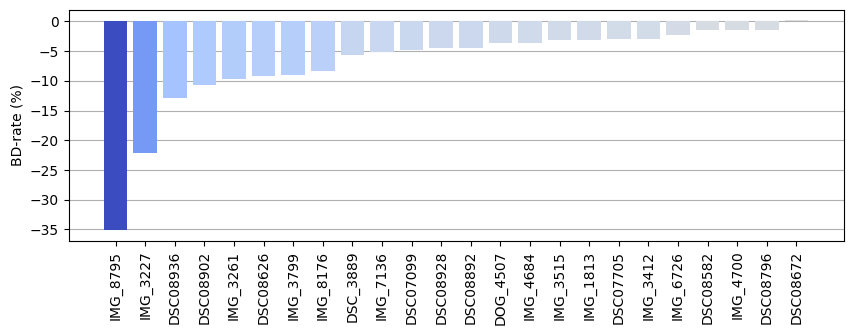

In [23]:
plot_img_results_comparison(ours_results[0.01], anchor_results["tcm"], anchor_results["vtm"])
plt.savefig(f"ours_tcm_imgwise_{dataset}.pdf", bbox_inches="tight")
plt.savefig(f"ours_tcm_imgwise_{dataset}.png", dpi=600, bbox_inches="tight")

[('IMG_8795', -27.785872020471245), ('IMG_3227', -17.263746265501442), ('DSC08902', -16.73690825779164), ('IMG_3261', -16.34941107855663), ('DSC08936', -15.362169812035953), ('DSC08626', -9.787019564030876), ('IMG_3799', -9.679913151213315), ('DSC08928', -9.299745652312897), ('IMG_3412', -9.046396663873423), ('DOG_4507', -7.06815218710275), ('IMG_6726', -6.943766501485838), ('IMG_8176', -6.8161404697894), ('IMG_3515', -6.519305712688128), ('IMG_4684', -6.352772249436112), ('DSC08892', -6.125932736491091), ('DSC07099', -5.46421919109923), ('IMG_7136', -5.392417260284677), ('DSC_3889', -5.305747043902242), ('DSC08582', -4.553079863358534), ('IMG_4700', -4.385138296704216), ('IMG_1813', -3.9170063479675665), ('DSC08796', -2.7486414110947877), ('DSC07705', -2.2889516998405917), ('DSC08672', -1.5269950700514512)]


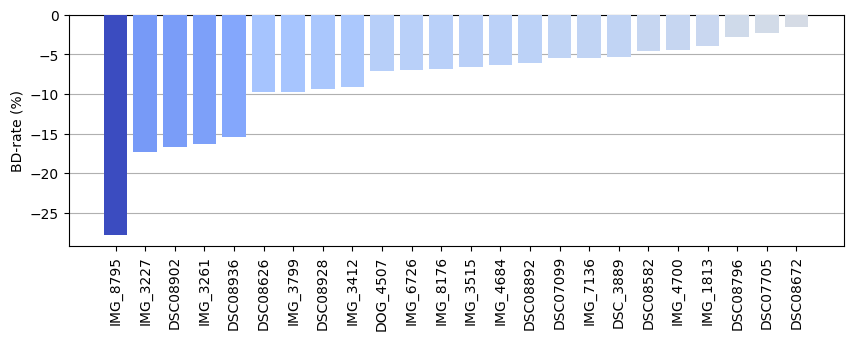

In [24]:
plot_img_results_comparison(
    ours_results[1.0], anchor_results["qarv"], anchor_results["vtm"]
)
plt.savefig(f"ours_qarv_imgwise_{dataset}.pdf", bbox_inches='tight')
plt.savefig(f"ours_qarv_imgwise_{dataset}.png", dpi=600, bbox_inches="tight")

[('DSC08892', -9.861583131897177), ('DSC08928', -7.647345490309021), ('DOG_4507', -7.207526090953198), ('DSC08796', -5.81988297799223), ('IMG_6726', -5.432060558883133), ('DSC07099', -5.363544266117137), ('DSC_3889', -4.087415968672126), ('IMG_4700', -3.496694627204655), ('IMG_3412', -2.9775045933545963), ('IMG_8176', -2.816356985081292), ('IMG_1813', -2.681546566125992), ('IMG_7136', -2.632484692108028), ('DSC08672', -2.225507152999706), ('IMG_3799', -2.0054855657527737), ('IMG_3227', -1.8936644262590452), ('IMG_8795', -1.8200673618943175), ('IMG_4684', -1.8196988702304462), ('DSC08902', -1.574730128164159), ('DSC08936', -1.3829498828238362), ('IMG_3515', -1.3489736897428384), ('DSC08582', -1.3221544845924527), ('DSC07705', -1.3124611405069708), ('IMG_3261', -0.34882870971261193), ('DSC08626', 0.9011786291550861)]


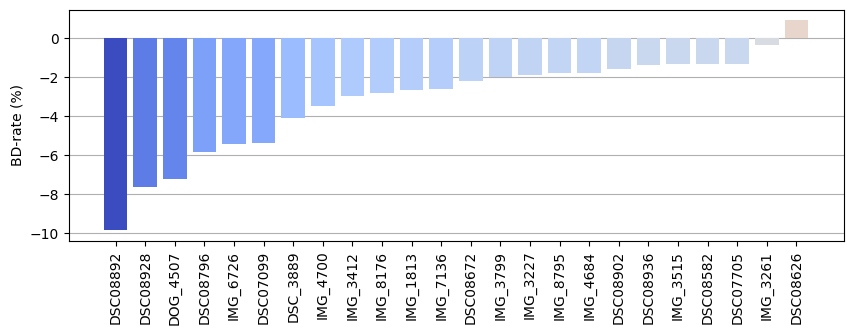

In [25]:
plot_img_results(
    ours_results[2.0], anchor_results["evc"]
)

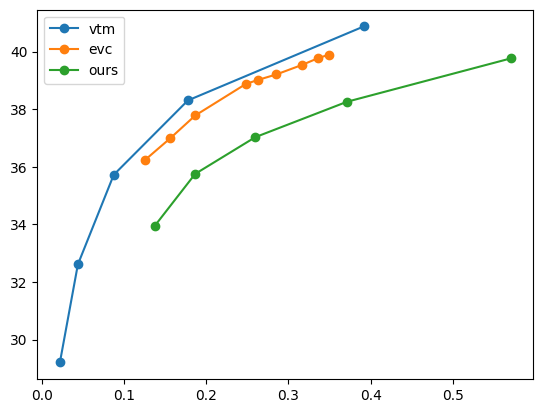

In [26]:
def f(imgresult, label):
    plt.plot([x.r for x in imgresult], [x.d for x in imgresult], label=label, marker='o')

f(anchor_results["vtm"].img_results["DSC08902"], "vtm")
f(anchor_results["evc"].img_results["DSC08902"], "evc")
# f(anchor_results["mlic"].img_results["DSC05885"], "mlic")
f(ours_results[3.0].img_results["DSC08902"], "ours")
plt.legend()

In [27]:
from src.fileio import FileIO

glb3 = glob.glob("classc/PSNR/speedup-2.0/*/DSC08927.bin")

for filename in glb3:
    fileio = FileIO.load(filename, False, 512)
    print(filename, fileio.method_id)

classc/PSNR/speedup-2.0/qscale-0.1/DSC08927.bin [1 4 0 4 4 1 0 1 4 0 0 1]
classc/PSNR/speedup-2.0/qscale-0.7/DSC08927.bin [1 1 0 1 1 1 1 1 1 1 1 1]
classc/PSNR/speedup-2.0/qscale-0.5/DSC08927.bin [1 1 0 1 1 1 0 1 1 1 1 4]
classc/PSNR/speedup-2.0/qscale-0.3/DSC08927.bin [1 1 0 4 4 1 0 1 4 0 0 4]
classc/PSNR/speedup-2.0/qscale-0.9/DSC08927.bin [1 1 0 1 1 1 1 1 1 0 1 1]
